# Assignment 1
In Section AE.1 in the ebook, the NN model is trained on the normal Reynolds stresses
in the boundary layer flow and then the Reynolds stresses in the two channel
flows ($Re_τ$ = 550 and $Re_τ$ = 5 200) are predicted. Do it the other way around:
use one of the channel flows as training data and predict the Reynolds stresses for
the other two flows. You need probably change the limits on y+ and ∂U+/∂y+.

## Setup

In [39]:
%load_ext autoreload
%autoreload 2

from LoadData import *
from Plot import *
from pathlib import Path
import numpy as np
import torch 
import sys 
import time
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from random import randrange
from joblib import dump, load

plt.rcParams.update({'font.size': 14})
plt.interactive(True)
plt.close('all')
# Create output path
outputPath = 'Output/'
Path("Output").mkdir(parents=True, exist_ok=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get DNS/LES data for channel flow, $Re = 5200$

In [2]:
minYplus = 50
maxYplus = 2000

y_DNS, yplus_DNS, u_DNS, uu_DNS, vv_DNS, ww_DNS, uv_DNS, k_DNS, eps_DNS, dudy_DNS = GetInputData('FullyDevelopedChannel_Re5200', minYplus, maxYplus)
c, a11_DNS, a33_DNS = GetC0andC2(k_DNS, eps_DNS, dudy_DNS, uu_DNS, vv_DNS, ww_DNS)

Returning data from: FullyDevelopedChannel_Re5200. Min yplus: 50. Max yplus: 2000
Returning c = [c0, c2], a11 and a33


## Plot to check that dissipation and production are balanced

In [3]:
plot = False

if plot:
    ########################## 2*a11_DNS+a33_DNS
    fig1,ax1 = plt.subplots()
    plt.subplots_adjust(left=0.20,bottom=0.20)
    ax1.scatter(2*a11_DNS+a33_DNS,yplus_DNS, marker="o", s=10, c="red", label="Neural Network")
    plt.xlabel("$2a_{11}+a_{33}$")
    plt.ylabel("$y^+$")
    plt.legend(loc="best",fontsize=12)
    #plt.savefig('Output/2a11_DNS+a33_DNS-dudy2-and-tau-2-hidden-9-yplus-2200-dudy-min-eq.4e-4-scale-with-k-eps-units-BL.png')


    prod_DNS_1 = -uv_DNS*dudy_DNS

    ########################## k-bal
    fig1,ax1 = plt.subplots()
    plt.subplots_adjust(left=0.20,bottom=0.20)
    #ax1.plot(yplus_DNS_uu,prod_DNS, 'b-', label="prod")
    ax1.plot(yplus_DNS,prod_DNS_1, 'b-', label="$-\\overline{u'v'} \\partial U/\\partial y$")
    ax1.plot(yplus_DNS,-eps_DNS,'r--', label="-diss")
    #plt.axis([0,200,0,0.3])
    plt.xlabel("$y^+$")
    plt.legend(loc="best",fontsize=12)
    #plt.savefig('Output/prod-diss-DNS-dudy2-and-tau-2-hidden-9-yplus-2200-dudy-min-eq.4e-4-scale-with-ustar-and-nu-BL.png')



## Calculate $\frac{du}{dy}$ and $\frac{du}{dy}^2$

In [4]:
# transpose the target vector to make it a column vector  
y = c.transpose()
tau_DNS = abs(k_DNS/eps_DNS)
dudy_squared_DNS = (dudy_DNS**2)
# scale with k and eps 
# dudy [1/T]
# dudy**2 [1/T**2]
T = tau_DNS
dudy_squared_DNS_scaled = dudy_squared_DNS*T**2
dudy_DNS_inv = 1/dudy_DNS/T
# re-shape
dudy_squared_DNS_scaled = dudy_squared_DNS_scaled.reshape(-1,1)
dudy_DNS_inv_scaled = dudy_DNS_inv.reshape(-1,1)
# use MinMax scaler
#scaler_dudy2 = StandardScaler()
#scaler_tau = StandardScaler()
scaler_dudy2 = MinMaxScaler()
scaler_dudy = MinMaxScaler()
X=np.zeros((len(dudy_DNS),2))
X[:,0] = scaler_dudy2.fit_transform(dudy_squared_DNS_scaled)[:,0]
X[:,1] = scaler_dudy.fit_transform(dudy_DNS_inv_scaled)[:,0]



## Create training and test set 

In [5]:

# split the feature matrix and target vector into training and validation sets
# test_size=0.2 means we reserve 20% of the data for validation
# random_state=42 is a fixed seed for the random number generator, ensuring reproducibility


indices = np.arange(len(X))

# Set test size to 0 for now
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(X, y, indices,test_size = 0.2 ,shuffle=True, random_state=42)

# convert the numpy arrays to PyTorch tensors with float32 data type
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

my_batch_size = 5
# create PyTorch datasets and dataloaders for the training and validation sets
# a TensorDataset wraps the feature and target tensors into a single dataset
# a DataLoader loads the data in batches and shuffles the batches if shuffle=True
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, shuffle=False, batch_size=my_batch_size)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=my_batch_size)

c_0_DNS = c[0, :]
c_2_DNS = c[1, :]

# Assertions instead of plotting the data
for i, k in enumerate(index_train):
    assert abs(c_0_DNS[k] - train_dataset[i][1][0].numpy()) < 0.000001, "Training set for C0 differs from input values!"
    assert abs(c_2_DNS[k] - train_dataset[i][1][1].numpy()) < 0.000001, "Training set for C2 differs from input values!"
    
for i, k in enumerate(index_test):
    assert abs(c_0_DNS[k] - test_dataset[i][1][0].numpy()) < 0.000001, "Test set for C0 differs from input values!"
    assert abs(c_2_DNS[k] - test_dataset[i][1][1].numpy()) < 0.000001, "Test set for C2 differs from input values!"



## Train model

In [6]:

class nn_turbML(nn.Module):

    def __init__(self, nNodes):
        super(nn_turbML, self).__init__()
        self.linears = nn.ModuleList([nn.Linear(2, nNodes), nn.Linear(nNodes, nNodes), nn.Linear(nNodes,2)])
        self.actFunction = nn.Sigmoid()

    def forward(self, x):
        for i, linear in enumerate(self.linears):
            x = linear(x)
            # No activation function on output layer
            if i == len(self.linears)-1:
                break
            x = self.actFunction(x)
        return x

def closure():
    for batch, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()  # Zero out gradients
        outputs = model(X)  # Forward pass through the model
        loss = loss_fn(outputs, y)  # Compute mean squared error loss

        # Calculate the L1 regularization term
        l1_regularization = torch.tensor(0.)
        for param in model.parameters():
            l1_regularization += torch.norm(param, p=1)  # L1 norm of model parameters

        # Add the L1 regularization term to the loss
        loss += lambda_l1 * l1_regularization  # Add L1 regularization to the loss
        loss.backward()  # Compute gradients
    return loss
  

def test_loop(dataloader, model, loss_fn):
    global pred_numpy,pred1,size1
    size = len(dataloader.dataset)
    size1 = size
    num_batches = len(dataloader)
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred_numpy = pred.detach().numpy()
    test_loss /= num_batches
    
    return test_loss

# Instantiate a neural network
model = nn_turbML(50)
# Initialize the loss function
loss_fn = nn.MSELoss()
# Set up hyperparameters
learning_rate = 0.5e-1
max_epochs = 10000
lambda_l1 = 0
prev_loss = float('inf') 

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
trainingloss_values = []
testloss_values = []
for epoch in range(max_epochs):
    loss = optimizer.step(closure)  # Optimize model parameters
    testloss = test_loop(test_loader, model, loss_fn)
    testloss_values.append(testloss)

    # Print the loss every 10th epoch
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{max_epochs}], Training loss: {loss:.7f}, Test loss: {testloss:.7f}")

    loss_change = prev_loss - loss.item()
    prev_loss = loss.item()
    trainingloss_values.append(prev_loss)


preds = model(X_test_tensor)
c0=preds.detach().numpy()[:,0]
c2=preds.detach().numpy()[:,1]

c0_std=np.std(c0-c_0_DNS[index_test])/(np.mean(c0.flatten()**2))**0.5
c2_std=np.std(c2-c_2_DNS[index_test])/(np.mean(c2.flatten()**2))**0.5

print('\nc0_error_std: ',c0_std)
print('\nc2_error_std: ',c2_std)


Epoch [10/10000], Training loss: 0.0001790, Test loss: 0.0001471
Epoch [20/10000], Training loss: 0.0001779, Test loss: 0.0001464
Epoch [30/10000], Training loss: 0.0001768, Test loss: 0.0001456
Epoch [40/10000], Training loss: 0.0001758, Test loss: 0.0001449
Epoch [50/10000], Training loss: 0.0001748, Test loss: 0.0001443
Epoch [60/10000], Training loss: 0.0001737, Test loss: 0.0001436
Epoch [70/10000], Training loss: 0.0001727, Test loss: 0.0001429
Epoch [80/10000], Training loss: 0.0001717, Test loss: 0.0001422
Epoch [90/10000], Training loss: 0.0001707, Test loss: 0.0001415
Epoch [100/10000], Training loss: 0.0001697, Test loss: 0.0001408
Epoch [110/10000], Training loss: 0.0001687, Test loss: 0.0001402
Epoch [120/10000], Training loss: 0.0001677, Test loss: 0.0001395
Epoch [130/10000], Training loss: 0.0001667, Test loss: 0.0001388
Epoch [140/10000], Training loss: 0.0001657, Test loss: 0.0001382
Epoch [150/10000], Training loss: 0.0001647, Test loss: 0.0001375
Epoch [160/10000], 

# Plot losses

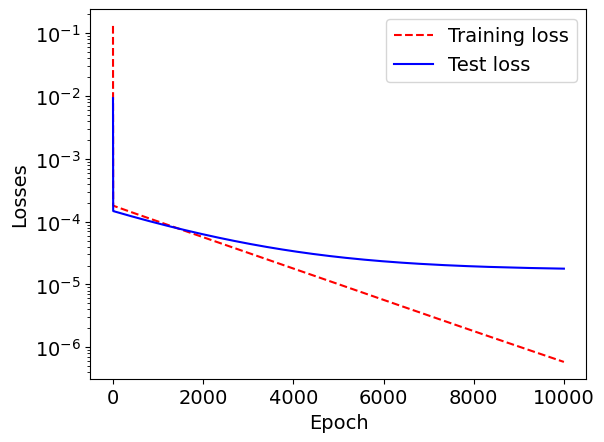

In [15]:
plt.semilogy(trainingloss_values, 'r--', label='Training loss')
plt.semilogy(testloss_values, 'b', label='Test loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.show()


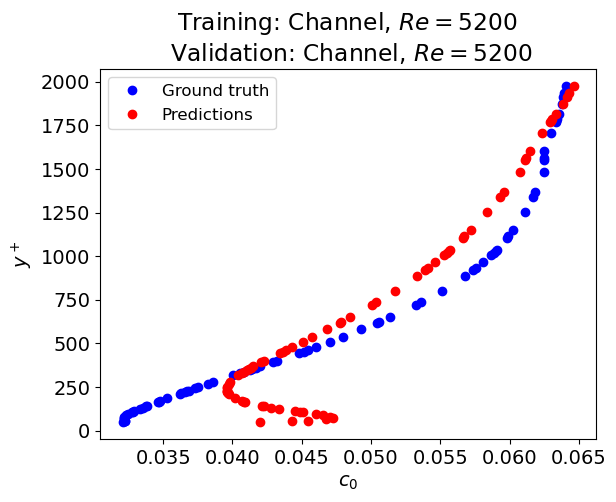

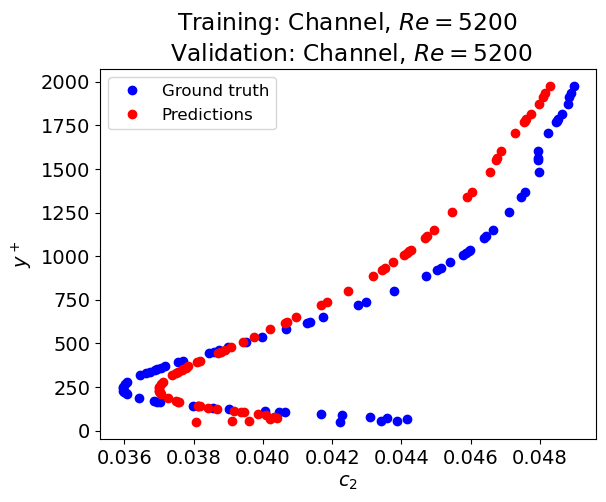

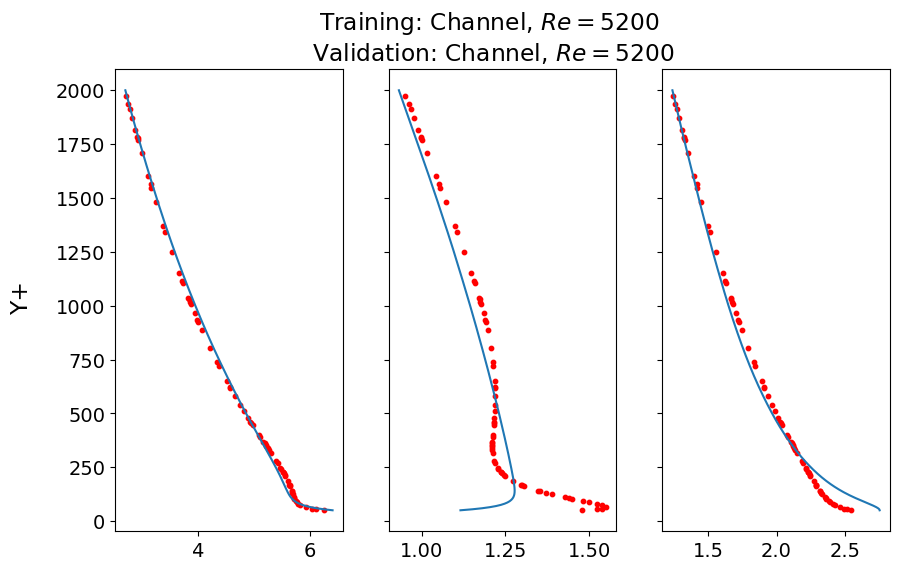

In [31]:
PlotData(yplus_DNS, uu_DNS, vv_DNS, ww_DNS, dudy_DNS, tau_DNS, k_DNS, c_0_DNS , c_2_DNS, c0, c2, index_test, index_train, 'Channel, $Re=5200$', 'Channel, $Re=5200$')

## Validate with boundary layer flow 

Returning data from: BoundaryLayer. Min yplus: 50. Max yplus: 2000
Returning c = [c0, c2], a11 and a33

c0_error_std:  0.12373431278636197

c2_error_std:  0.10545546042664114


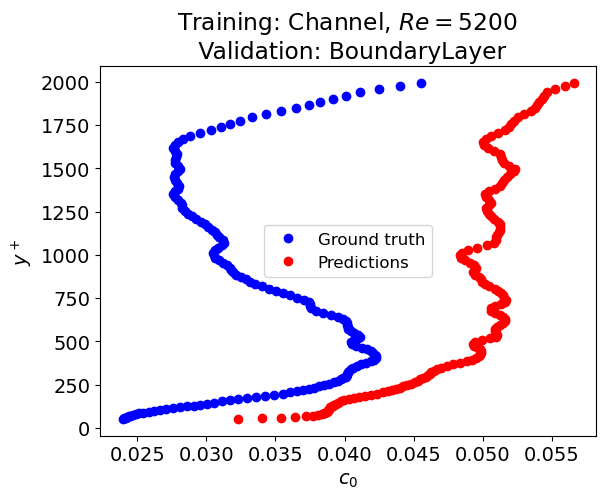

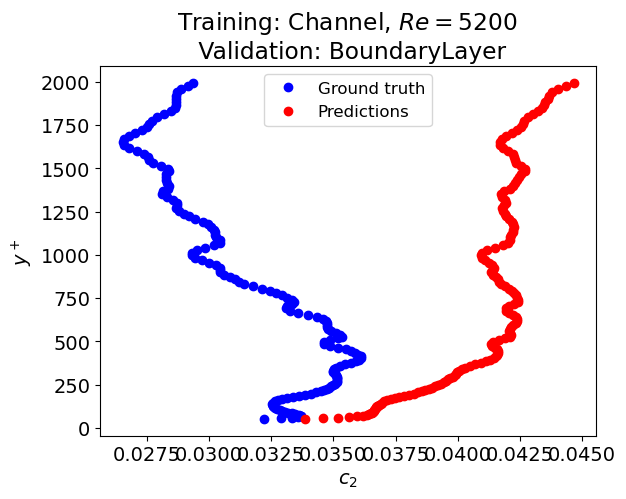

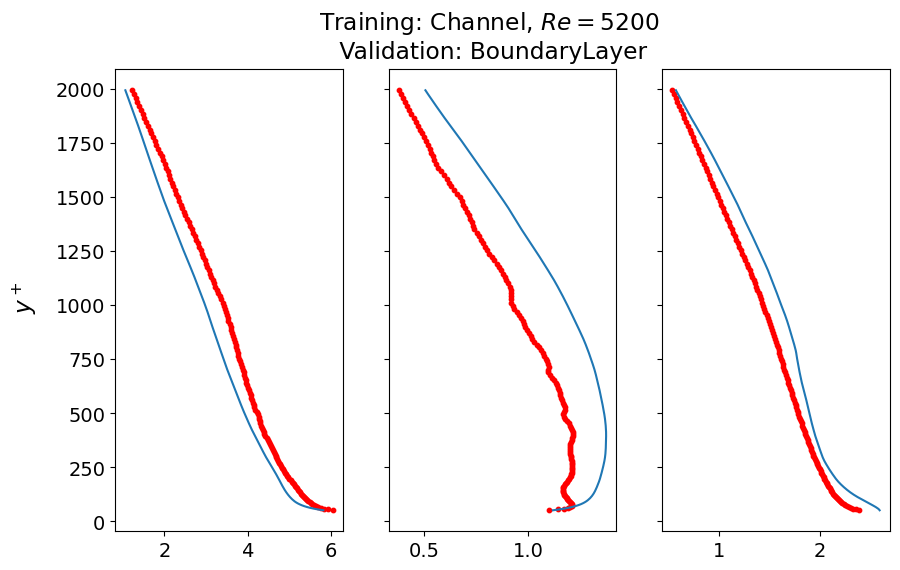

In [41]:
y_DNS, yplus_DNS, u_DNS, uu_DNS, vv_DNS, ww_DNS, uv_DNS, k_DNS, eps_DNS, dudy_DNS = GetInputData('BoundaryLayer', minYplus, maxYplus)
c, a11_DNS, a33_DNS = GetC0andC2(k_DNS, eps_DNS, dudy_DNS, uu_DNS, vv_DNS, ww_DNS)

c_0_DNS_validation = c[0, :]
c_2_DNS_validation = c[1, :]
# transpose the target vector to make it a column vector  
y = c.transpose()
tau_DNS = abs(k_DNS/eps_DNS)
dudy_squared_DNS = (dudy_DNS**2)
# scale with k and eps 
# dudy [1/T]
# dudy**2 [1/T**2]
T = tau_DNS
dudy_squared_DNS_scaled = dudy_squared_DNS*T**2
dudy_DNS_inv = 1/dudy_DNS/T
# re-shape
dudy_squared_DNS_scaled = dudy_squared_DNS_scaled.reshape(-1,1)
dudy_DNS_inv_scaled = dudy_DNS_inv.reshape(-1,1)
# use MinMax scaler
#scaler_dudy2 = StandardScaler()
#scaler_tau = StandardScaler()

## We have to use the same scaler as for the training data set
X=np.zeros((len(dudy_DNS),2))
X[:,0] = scaler_dudy2.transform(dudy_squared_DNS_scaled)[:,0]
X[:,1] = scaler_dudy.transform(dudy_DNS_inv_scaled)[:,0]

X = torch.tensor(X, dtype=torch.float32)

predictions_Boundary = model(X)

c_NN = predictions_Boundary.detach().numpy()
 
c_NN_old = c_NN

c0=c_NN[:,0]
c2=c_NN[:,1]

c0_std=np.std(c0-c_0_DNS_validation)/(np.mean(c0.flatten()**2))**0.5
c2_std=np.std(c2-c_2_DNS_validation)/(np.mean(c2.flatten()**2))**0.5

print('\nc0_error_std: ',c0_std)
print('\nc2_error_std: ',c2_std)

PlotData(yplus_DNS, uu_DNS, vv_DNS, ww_DNS, dudy_DNS, tau_DNS, k_DNS, c_0_DNS_validation, c_2_DNS_validation, c0, c2, None, None, 'Channel, $Re=5200$', 'BoundaryLayer')


## Validate with channel flow, $Re = 550$ 

Returning data from: FullyDevelopedChannel_Re550. Min yplus: 20. Max yplus: 400
Returning c = [c0, c2], a11 and a33

c0_error_std:  0.13163381867799723

c2_error_std:  0.11127585071401527


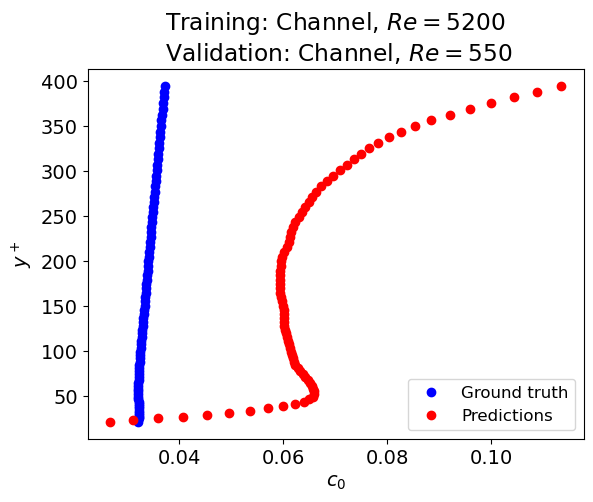

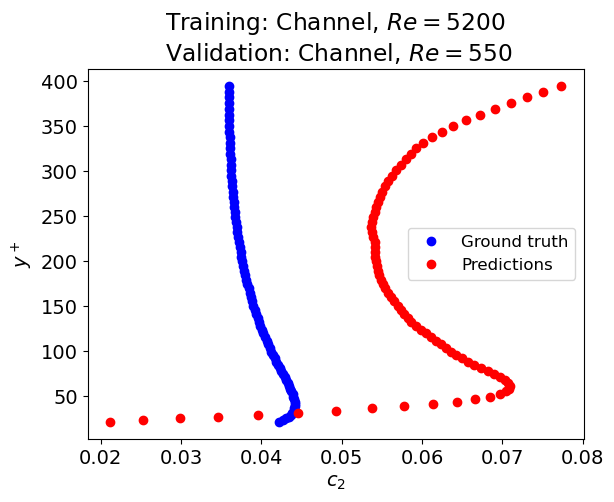

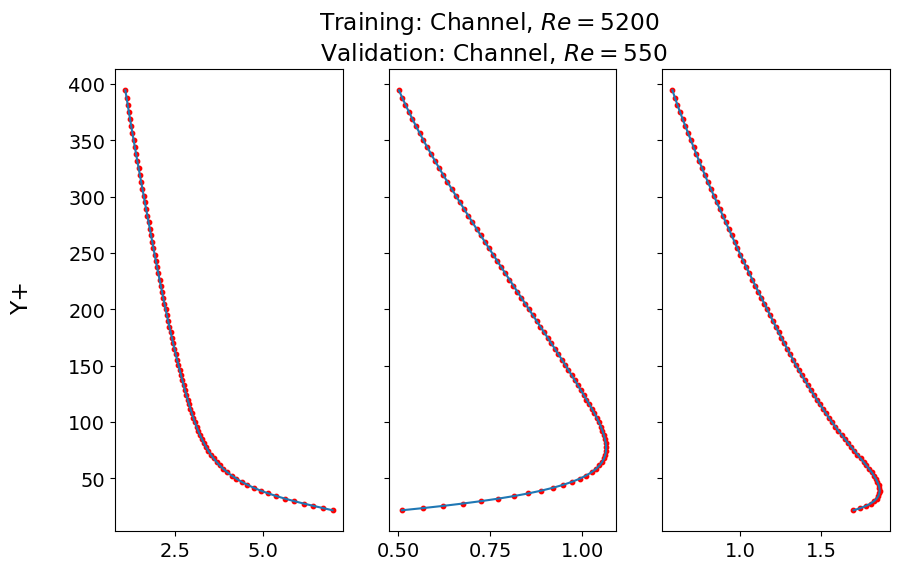

In [38]:
y_DNS, yplus_DNS, u_DNS, uu_DNS, vv_DNS, ww_DNS, uv_DNS, k_DNS, eps_DNS, dudy_DNS = GetInputData('FullyDevelopedChannel_Re550', 20, 400)
c, a11_DNS, a33_DNS = GetC0andC2(k_DNS, eps_DNS, dudy_DNS, uu_DNS, vv_DNS, ww_DNS)

c_0_DNS_validation = c[0, :]
c_2_DNS_validation = c[1, :]
# transpose the target vector to make it a column vector  
y = c.transpose()
tau_DNS = abs(k_DNS/eps_DNS)
dudy_squared_DNS = (dudy_DNS**2)
# scale with k and eps 
# dudy [1/T]
# dudy**2 [1/T**2]
T = tau_DNS
dudy_squared_DNS_scaled = dudy_squared_DNS*T**2
dudy_DNS_inv = 1/dudy_DNS/T
# re-shape
dudy_squared_DNS_scaled = dudy_squared_DNS_scaled.reshape(-1,1)
dudy_DNS_inv_scaled = dudy_DNS_inv.reshape(-1,1)
# use MinMax scaler
#scaler_dudy2 = StandardScaler()
#scaler_tau = StandardScaler()

## We have to use the same scaler as for the training data set
X=np.zeros((len(dudy_DNS),2))
X[:,0] = scaler_dudy2.transform(dudy_squared_DNS_scaled)[:,0]
X[:,1] = scaler_dudy.transform(dudy_DNS_inv_scaled)[:,0]

X = torch.tensor(X, dtype=torch.float32)

predictions_Boundary = model(X)

c_NN = predictions_Boundary.detach().numpy()
 
c_NN_old = c_NN

c0=c_NN[:,0]
c2=c_NN[:,1]

c0_std=np.std(c0-c_0_DNS_validation)/(np.mean(c0.flatten()**2))**0.5
c2_std=np.std(c2-c_2_DNS_validation)/(np.mean(c2.flatten()**2))**0.5

print('\nc0_error_std: ',c0_std)
print('\nc2_error_std: ',c2_std)

PlotData(yplus_DNS, uu_DNS, vv_DNS, ww_DNS, dudy_DNS, tau_DNS, k_DNS, c_0_DNS_validation, c_2_DNS_validation, c0, c2, None, None, 'Channel, $Re=5200$', 'Channel, $Re=550$')